In [1]:
%matplotlib inline

In [1]:
import itertools
import json
import random
from typing import List, Tuple, Dict, Any, Iterator

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm

import Levenshtein

In [19]:
def scansion_distance(a: List[int], b: List[int]) -> float:
    a, b = ''.join(map(str, a)), ''.join(map(str, b))
    return Levenshtein.ratio(a, b)

def normalize_stress(stress_pattern: List[str]) -> List[int]:
    return [int(elt) if isinstance(elt, (int, float)) or elt.isdigit() else 0 for elt in stress_pattern]

def get_stress_patterns(song: Dict) -> Iterator[List[int]]:
    for verse in song['text']:
        patterns = []
        for line in verse:
            pattern = normalize_stress([
                syl for elt in line for syl in elt['beat']
            ])
            patterns.append(pattern)
        yield patterns

In [20]:
with open('../data/mcflow/mcflow-large.json') as f:
    data = json.load(f)

In [58]:
scores = {'pairs': [], 'random pairs': []}
all_lines = []

for song in tqdm.tqdm(data):
    lines = []
    for patterns in get_stress_patterns(song):
        # compute overall coherence in a stanza
        assert len(patterns) > 1
        sims = [D(a, b) for a, b in zip(patterns, patterns[1:])]
        scores['pairs'].extend(sims)
        all_lines.extend(patterns)

# compute coherence based on random pairings
for song in tqdm.tqdm(data):
    for patterns in get_stress_patterns(song):
        assert len(patterns) > 1
        patterns = random.sample(all_lines, min(len(patterns) * 10, len(all_lines)))
        sims = [D(a, b) for a, b in zip(patterns, patterns[1:])]
        scores['random pairs'].extend(sims)

100%|██████████| 123/123 [00:00<00:00, 309.20it/s]


/Users/folgertkarsdorp/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


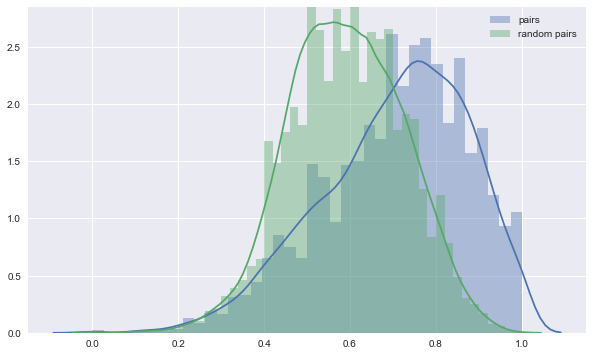

In [59]:
plt.figure(figsize=(10, 6))
sns.distplot(scores['pairs'], label='pairs')
sns.distplot(scores['random pairs'], label='random pairs')
plt.legend();

In [39]:
import scipy.stats as stats

K, p = stats.ks_2samp(scores['pairs'], scores['random pairs'])
print(f'K={K:.3f}, p={p:.3f}')
Z, p = stats.ranksums(scores['pairs'], scores['random pairs'])
print(f'Z={Z:.3f}, p={p:.3f}')

K=0.330, p=0.000
Z=38.295, p=0.000


In [66]:
import statistics

def bootstrap_p(a, b, N=9_999):
    def H(u, v):
        return 1 if a > b else 0.5 if a == b else 0
    
    n = min(len(a), len(b))
    p = 0
    for _ in tqdm.tqdm(range(N)):
        p += H(statistics.mean(random.sample(a, n)),
               statistics.mean(random.sample(b, n)))
    p /= N
    return (1 + 2 * N * min(p, 1 - p)) / (1 + N)

In [67]:
bootstrap_p(scores['pairs'], scores['random pairs'])

100%|██████████| 9999/9999 [02:47<00:00, 59.79it/s]


0.0001